In [1]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy
import networkx as nx

from tqdm import tqdm
from sensitivity import sensitivity_analysis

### Sensitivity Analysis for model comparison
$$min\quad ||d||_{2}$$
$$s.t.\quad Nd = 0$$
$$\qquad d_{[k]} = \delta_{[k]}$$

Where we solve for sensitivities as:  
$$ s_{[i,k]} = \frac{d_{i}}{\delta_{k}}$$

With a non-zero reference flux from FBA we can also scale the disturbances with $r_{i} = \frac{d_{i}}{v^{ref}_{i}}$ and solve for relative sensitivities using $r$. This method causes problems when reference fluxes are close to 0.  

See [10.3182/20080706-5-KR-1001.02684](https://doi.org/10.3182/20080706-5-KR-1001.02684) and https://doi.org/10.1038/s41467-023-37429-5 for more details

In [2]:
cobra.Configuration.solver = 'glpk'
elong = cobra.io.read_sbml_model("model_files/iJB785_rubisco_limited_for_MED4.xml")

elong_reactions = [rxn.id for rxn in elong.reactions]
elong_metabolites = [met.id for met in elong.metabolites]

med4 = cobra.io.load_json_model("model_files/ProchlorococcusMED4v1.json")

med4_reactions = [rxn.id for rxn in med4.reactions]
med4_metabolites = [met.id for met in med4.metabolites]

elong_to_MED4 = json.load(open("model_files/elongatus_to_med4_reactions.json"))

In [3]:
elong_to_MED4['BIOMASS__1'] = "BIOMASS"

## Generate reference matrices

n stoichiometry matrix  
v reference fluxes

In [1]:
amgs_ofaim = json.load(open("model_files/amg_reactions_med4.json", 'r'))

amgs_elong = json.load(open("model_files/amg_reactions_iJB785.json", 'r'))

amg_pairs = {
    "FAKEOrthophosphateEX": "EX_pi_e",
    "PSIIabs": "PSIIum",
    "R00311": "HOXGfx",
    "R00426": "NTPP2",
    "R00662": "NTPP8",
    "R01063": "GAPDi_nadp",
    "R01523": "PRUK",
    "R01827": "TALA",
    "R02017": "RNDR1",
    "R02018": "RNDR4",
    "R02019": "RNDR2",
    "R02024": "RNDR3",
    "R05223": "ADOCBLS",
    "R05817": "PHYFXOR",
    }

amgs_genes = json.load(open("model_files/amg_gene_map_iJB785.json", 'r'))

NameError: name 'json' is not defined

In [2]:
# n = reaction stoichiometry matrix 
elong_n = pd.DataFrame(0, columns=elong_reactions, index=elong_metabolites, dtype=float)

for rxn in elong_reactions: 
    for met in elong.reactions.get_by_id(rxn).metabolites:
        elong_n.loc[met.id, rxn] = elong.reactions.get_by_id(rxn).metabolites[met]

# v = flux matrix 

# Use FVA midpoints 
elong_v_fva = pd.DataFrame(index=elong_reactions, columns=['reference flux'])
fva_elong_healthy = cobra.flux_analysis.flux_variability_analysis(elong)

for rxn in elong_reactions: 
    elong_v_fva.loc[rxn, 'reference flux'] = (fva_elong_healthy.loc[rxn, 'maximum'] + fva_elong_healthy.loc[rxn, 'minimum']) / 2

med4_n = pd.DataFrame(0, columns=med4_reactions, index=med4_metabolites, dtype=float)

for rxn in med4_reactions: 
    for met in med4.reactions.get_by_id(rxn).metabolites:
        med4_n.loc[met.id, rxn] = med4.reactions.get_by_id(rxn).metabolites[met]

## v = flux matrix 

# Use FVA midpoints
med4_v_fva = pd.DataFrame(index=med4_reactions, columns=['reference flux'])
fva_med4_healthy = cobra.flux_analysis.flux_variability_analysis(med4)

for rxn in med4_reactions: 
    med4_v_fva.loc[rxn, 'reference flux'] = (fva_med4_healthy.loc[rxn, 'maximum'] + fva_med4_healthy.loc[rxn, 'minimum']) / 2

NameError: name 'pd' is not defined

In [11]:
shared_rxns = list(elong_to_MED4.keys())

In [12]:
amg_pairs

{'FAKEOrthophosphateEX': 'EX_pi_e',
 'PSIIabs': 'PSIIum',
 'R00311': 'HOXGfx',
 'R00426': 'NTPP2',
 'R00662': 'NTPP8',
 'R01063': 'GAPDi_nadp',
 'R01523': 'PRUK',
 'R01827': 'TALA',
 'R02017': 'RNDR1',
 'R02018': 'RNDR4',
 'R02019': 'RNDR2',
 'R02024': 'RNDR3',
 'R05223': 'ADOCBLS',
 'R05817': 'PHYFXOR',
 'R01528': 'GND',
 'R02736': 'G6PDH2r'}

phoH: EX_pi_e/FAKEOrthophosphateEX
Target flux for EX_pi_e set to -0.05307739738606543. Reference flux is -0.04426100746016752
Target flux for FAKEOrthophosphateEX set to -0.050297050689466286. Reference flux is -0.03577143167373181

psbA/psbD: PSIIum/PSIIabs
Target flux for PSIIum set to 237.75145866076474. Reference flux is 127.53998647237115
Target flux for PSIIabs set to 929.2693726287796. Reference flux is 499.9910537792483

ho1: HOXGfx/R00311
Target flux for HOXGfx set to 0.00010702311435923048. Reference flux is 0.00010707665267890653
Target flux for R00311 set to 313.30145685079196. Reference flux is 164.86970061180045

mazG: NTPP2/R00426
Target flux for NTPP2 set to 929.9981541560014. Reference flux is 489.4515941644123
Target flux for R00426 set to 330.67199891808195. Reference flux is 173.91236784587014

mazG: NTPP8/R00662
Target flux for NTPP8 set to 949.950785246681. Reference flux is 499.9738358568215
Target flux for R00662 set to 330.67199891808207. Reference flux is 173

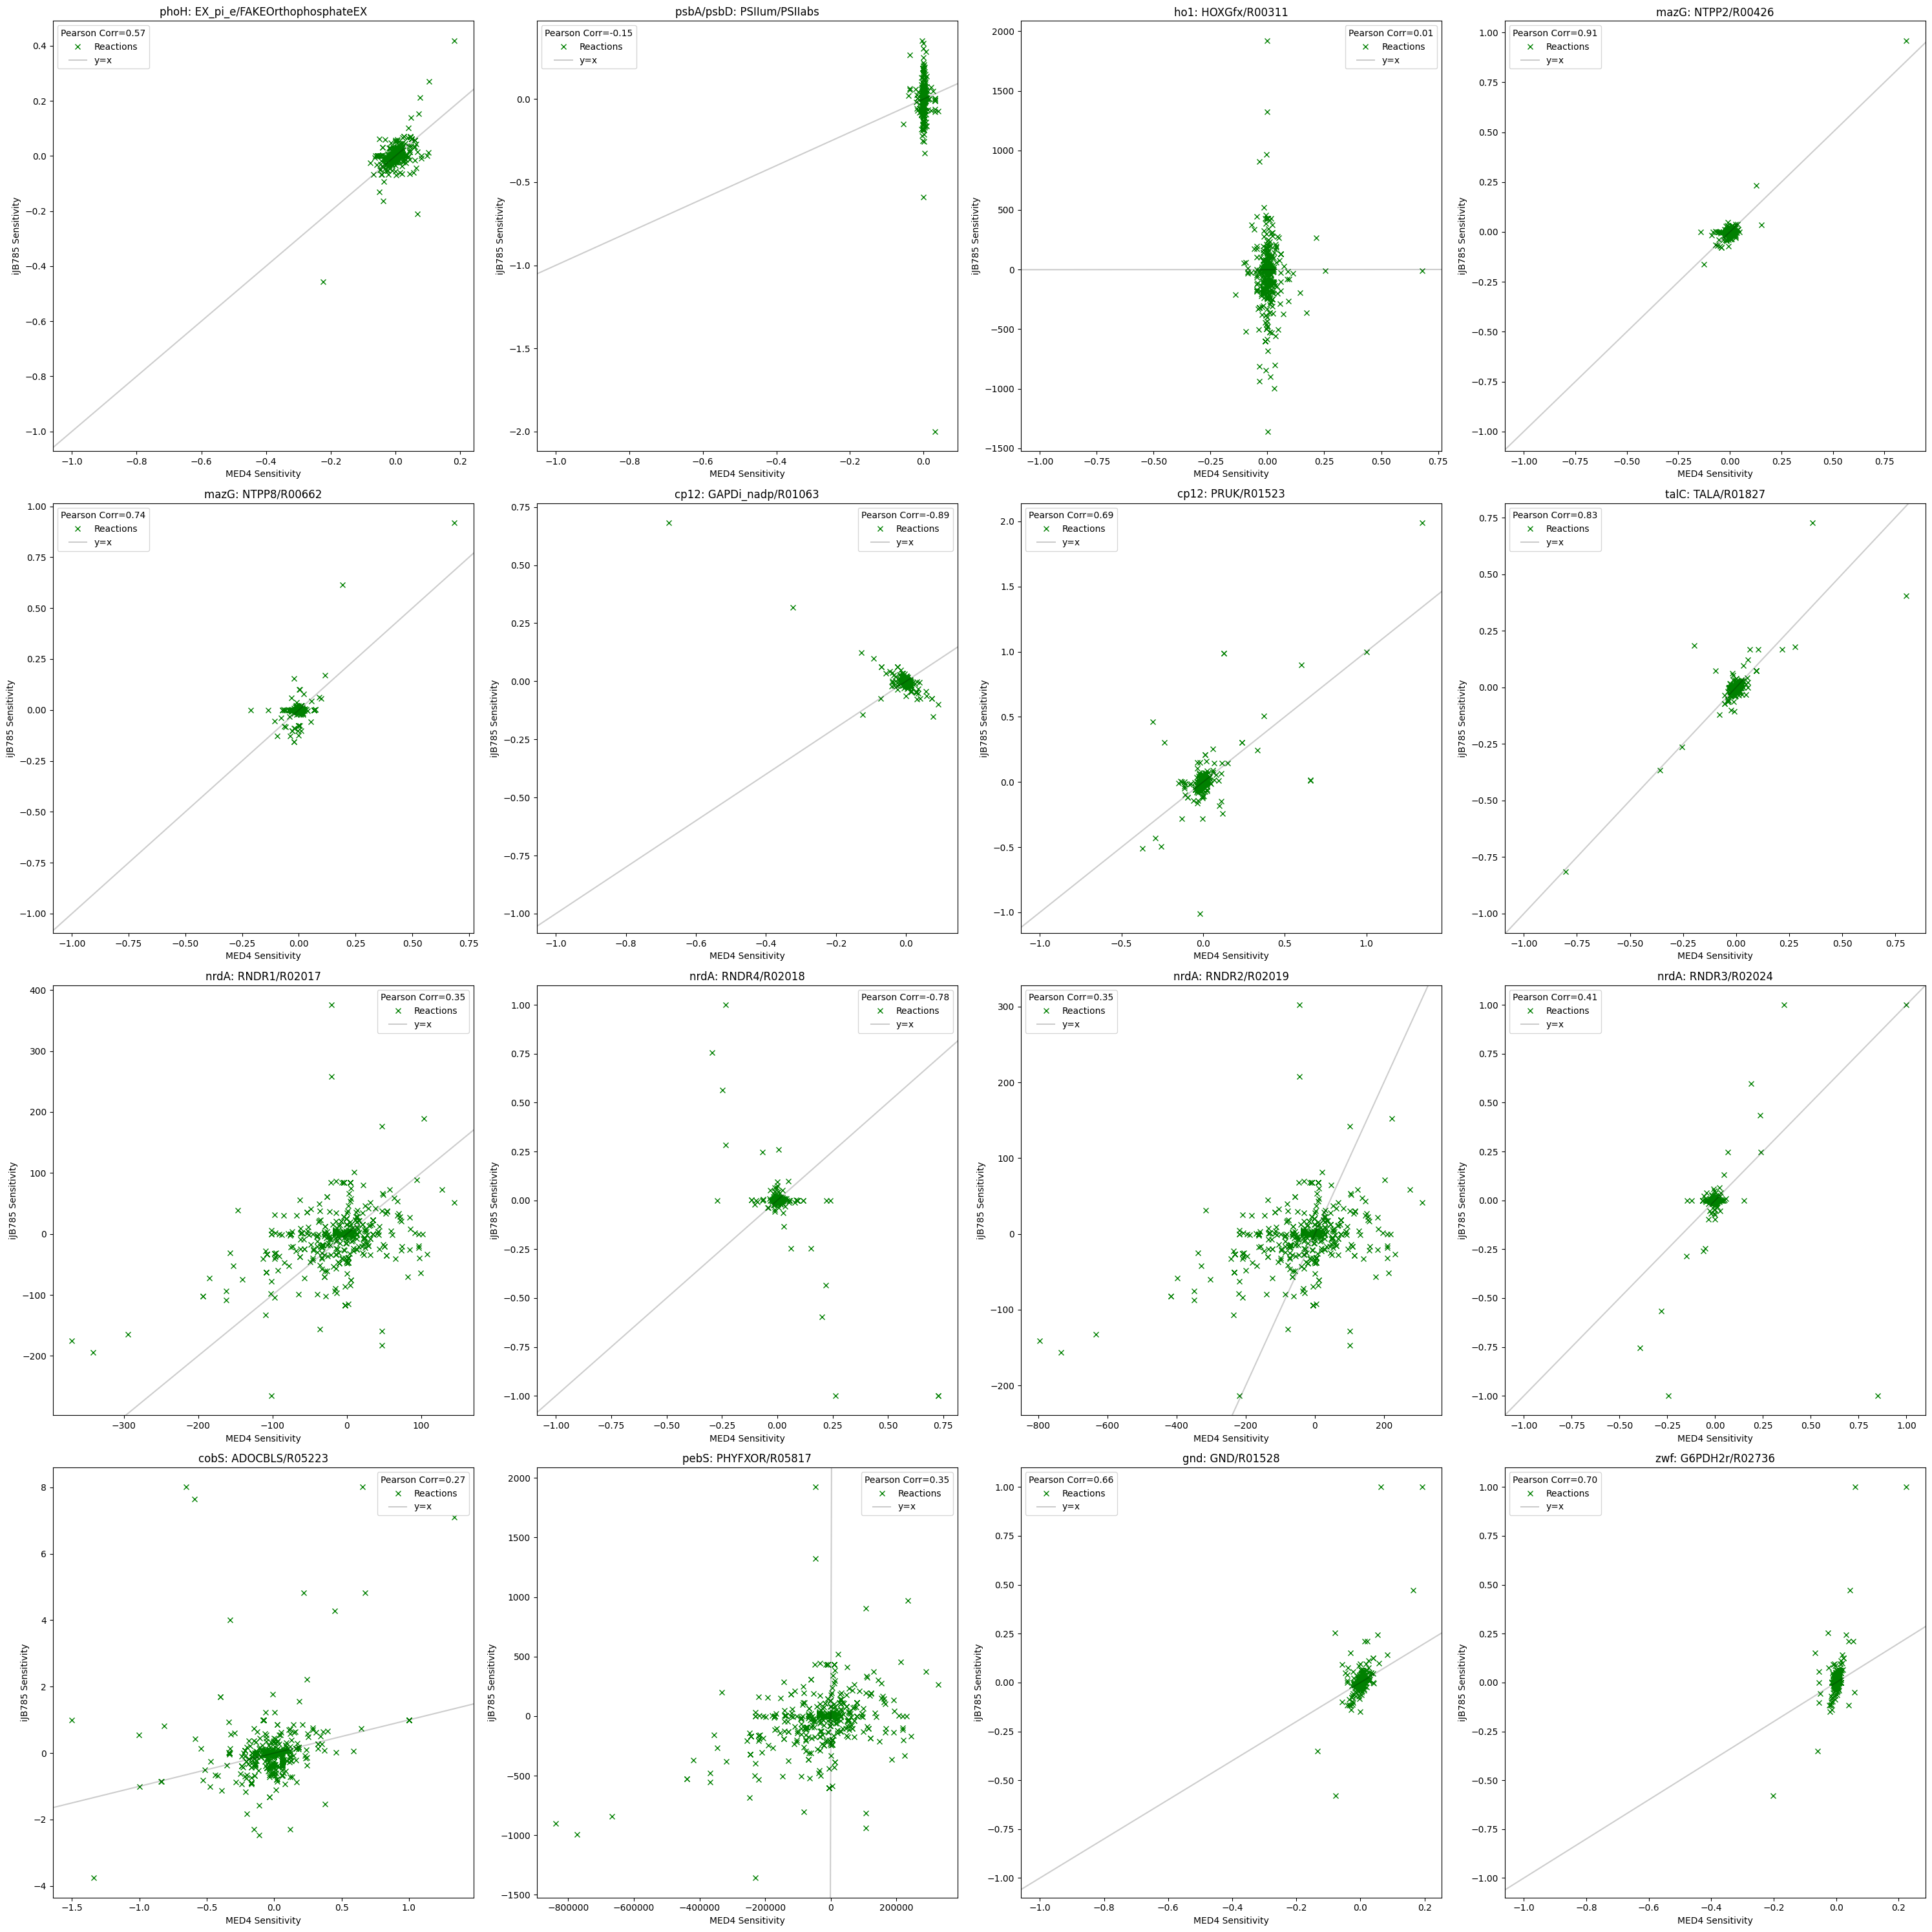

In [13]:
fig, axs = plt.subplots(4,4,figsize=(30,30))

for (m,e), ax in zip(amg_pairs.items(), axs.flatten()):
    title = f'{amgs_genes[e]}: {e}/{m}'
    print(title)
    e_d_fva, e_s_fva, e_r_fva, e_dk_fva = sensitivity_analysis(elong, elong_n, elong_v_fva, {e: amgs_elong[e]}, optimum_fraction=0.99, fva_targets=True, print_targets=True) 
    m_d_fva, m_s_fva, m_r_fva, m_dk_fva = sensitivity_analysis(med4, med4_n, med4_v_fva, {m: amgs_ofaim[m]}, optimum_fraction=0.99, fva_targets=True, print_targets=True)
    print()
    amg_fva = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
    for rxn in shared_rxns:
        if rxn in [e]:
            continue
        else:
            amg_fva.loc[rxn, 'MED4'] = m_s_fva.loc[elong_to_MED4[rxn], m]
            amg_fva.loc[rxn, 'iJB785'] = e_s_fva.loc[rxn, e]

    amg_fva = amg_fva.dropna()
    
    r = scipy.stats.pearsonr(amg_fva['MED4'], amg_fva['iJB785']).statistic

    ax.plot(amg_fva['MED4'], amg_fva['iJB785'], 'gx', label='Reactions')
    ax.set_xlabel("MED4 Sensitivity")
    ax.set_ylabel("iJB785 Sensitivity")
    ax.set_title(title)
    ax.axline((-1, -1), slope=1, label='y=x', color = 'k', alpha=0.2)
    ax.legend(title=f'Pearson Corr={r:.2f}')

plt.tight_layout()
plt.show()

## Analyze sensitivities of CP12 in both models

Setting amg targets by a factor of 2 for increase or decrease

In [46]:
elong_disturbances, elong_sensitivities, elong_residual, dk = sensitivity_analysis(elong, elong_n, elong_v_fba, {'GAPDi_nadp': 'absolute decrease', 'PRUK': 'absolute decrease'}, optimum_fraction=0.5,  print_targets=True) 
med4_disturbances, med4_sensitivities, med4_residual, med4_dk = sensitivity_analysis(med4, med4_n, med4_v_fba, {'R01063': 'absolute decrease', 'R01523': 'absolute decrease'}, optimum_fraction=0.5, print_targets=True)

Target flux for GAPDi_nadp set to 4.315285806098843. Reference flux is 8.630571612197686
Target flux for PRUK set to 2.3500000000000005. Reference flux is 4.700000000000001
Target flux for R01063 set to -4.469220779664468. Reference flux is -8.938441559328936
Target flux for R01523 set to 2.3500000000000005. Reference flux is 4.700000000000001


### $\delta_{k}$ arrays show the flux adjustment set for the targeted reactions

In [47]:
dk

array([[np.float64(-4.315285806098843)],
       [np.float64(-2.3500000000000005)]], dtype=object)

In [48]:
med4_dk

array([[np.float64(4.469220779664468)],
       [np.float64(-2.3500000000000005)]], dtype=object)

### disturbance arrays show the solution for $d$ that minimizes the adjustments for $Nd=0$ with $\delta_{k}$

In [49]:
elong_disturbances.sort_values(by='flux adjustment', ascending=False)

,flux adjustment
Htcx,2.3735
RPE,1.203496
TPI,0.988894
PGM,0.763092
FBA,0.552487
...,...
HCO3tcx,-2.3265
RB15BPtcx,-2.35
RBPCcx,-2.35
PGK,-2.9778


In [50]:
med4_disturbances.sort_values(by='flux adjustment', ascending=False)

,flux adjustment
R01529,0.747943
R02036,0.525111
R05605,0.525111
R01518,0.418971
O2TRANS,0.303674
...,...
GlycolateEX,-1.416728
R01061,-1.979904
D_Ribulose_1_5_bisphosphateTRANScar,-2.35
R01512,-2.489317


In [51]:
elong_sensitivities

,GAPDi_nadp,PRUK
EX_gln__L_e,-0.005932,-0.010892
EX_hco3_e,-0.082698,-0.151857
EX_mn2_e,0.0,0.0
EX_arg__L_e,-0.052259,-0.095963
ADPT,-0.016778,-0.030809
...,...,...
EX_4hbz_e,0.0131,0.024056
mal__Ltex,-0.010942,-0.020092
EX_mal__L_e,-0.010942,-0.020092
bm_protex,0.019979,0.036687


In [52]:
med4_sensitivities

,R01063,R01523
R01055,-0.0,0.0
R00546,0.0,-0.0
R05605,0.117495,-0.223451
R00346,0.001383,-0.00263
R00355,0.018312,-0.034825
...,...,...
S_MalateEX,0.006248,-0.011883
R01078,-0.0,0.0
Trans_H2O2,0.061191,-0.116373
H2O2EX,0.061191,-0.116373


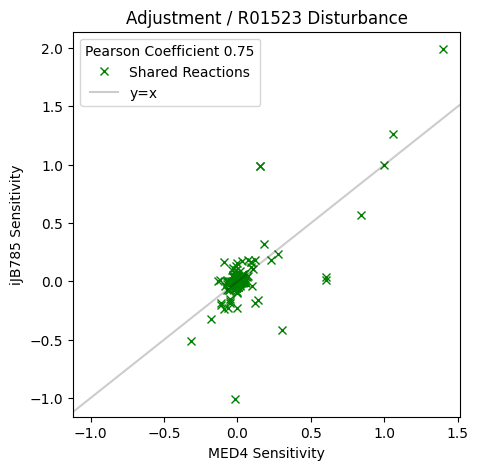

In [53]:
shared_rxns = list(elong_to_MED4.keys())

pruk = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
gapd = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
for rxn in shared_rxns:
    if rxn in ['GAPDi_nadp', 'PRUK']:
        continue
    else:
        pruk.loc[rxn, 'MED4'] = med4_sensitivities.loc[elong_to_MED4[rxn], 'R01523']
        pruk.loc[rxn, 'iJB785'] = elong_sensitivities.loc[rxn, 'PRUK']
        gapd.loc[rxn, 'MED4'] = med4_sensitivities.loc[elong_to_MED4[rxn], 'R01063']
        gapd.loc[rxn, 'iJB785'] = elong_sensitivities.loc[rxn, 'GAPDi_nadp']

pruk = pruk.dropna()
gapd = gapd.dropna()

rs = [scipy.stats.pearsonr(pruk['MED4'], pruk['iJB785']).statistic, scipy.stats.pearsonr(gapd['MED4'], gapd['iJB785']).statistic]
rxns = ['R01523', 'R01063']

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(pruk['MED4'], pruk['iJB785'], 'gx', label='Shared Reactions')
ax.axline((-1, -1), slope=1, label='y=x', color = 'k', alpha=0.2)
ax.legend(title=f'Pearson Coefficient {rs[0]:.2f}')
ax.set_title("Adjustment / R01523 Disturbance")
ax.set_xlabel("MED4 Sensitivity")
ax.set_ylabel("iJB785 Sensitivity")

# fig, ax = plt.subplots(1,2, figsize=(5,5))

# ax[0].plot(pruk['MED4'], pruk['iJB785'], 'gx', label='Shared Reactions')
# ax[0].axline((-1, -1), slope=1, label='y=x', color = 'k', alpha=0.2)
# ax[0].legend(title=f'Pearson Coefficient {rs[0]:.2f}')
# ax[1].plot(gapd['MED4'], gapd['iJB785'], 'gx', label='Shared Reactions')
# ax[1].axline((-0.8, 0.8), slope=-1, label='y=-x', color = 'k', alpha=0.2)
# ax[1].legend(title=f'Pearson Coefficient {rs[1]:.2f}')


# ax[0].set_title("Adjustment / R01523 Disturbance")
# ax[0].set_xlabel("MED4 Sensitivity")
# ax[0].set_ylabel("iJB785 Sensitivity")

# ax[1].set_title("Adjustment / R01063 Disturbance")
# ax[1].set_xlabel("MED4 Sensitivity")
# ax[1].set_ylabel("iJB785 Sensitivity")

plt.savefig("CP12_sensitivity.pdf", dpi=1200)
plt.show()

## Look into overall model similarity 

- We perturb every shared reaction as a raw increase, then calculate the correlation of the two models sensitivities to each perturbation pair
- The correlation distribution is plotted for the 514 shared reactions

### Find Jaccard Indices by subsystem

In [19]:
med4_subsystems = {}
elong_subsystems = {}

for rxn in med4.reactions:
    if rxn.subsystem not in med4_subsystems.keys(): 
        med4_subsystems[rxn.subsystem] = [rxn.id]
    else: 
        med4_subsystems[rxn.subsystem] = med4_subsystems[rxn.subsystem] + [rxn.id]

for rxn in elong.reactions:
    if rxn.subsystem not in elong_subsystems.keys(): 
        elong_subsystems[rxn.subsystem] = [rxn.id]
    else: 
        elong_subsystems[rxn.subsystem] = elong_subsystems[rxn.subsystem] + [rxn.id]

jaccard_subs = {}

for sub in elong_subsystems.keys():
    if sub in med4_subsystems.keys():
        med4_set = set(med4_subsystems[sub])
        elong_set = set(elong_to_MED4[rxn] if rxn in elong_to_MED4.keys() else rxn for rxn in elong_subsystems[sub])
        intersection = med4_set.intersection(elong_set)
        union = med4_set.union(elong_set)

        if union:
            jaccard_subs[sub] = len(intersection) / len(union)
        else: 
            jaccard_subs[sub] = 0

In [21]:
print(elong_subsystems.keys())
print(med4_subsystems.keys() - elong_subsystems.keys())

dict_keys(['Exchange Reaction', 'Purine metabolism', 'Transport', '', 'Folate biosynthesis', 'Nitrogen metabolism', 'Pyrimidine metabolism', 'Arginine and proline metabolism', 'Maintenance Reaction', 'Fatty acid biosynthesis', 'Phenylalanine, tyrosine and tryptophan biosynthesis', 'Histidine metabolism', 'Pentose phosphate pathway', 'Glycolysis / Gluconeogenesis', 'Ubiquinone and other terpenoid-quinone biosynthesis', 'Citrate cycle (TCA cycle)', 'Valine, leucine and isoleucine biosynthesis', 'Cysteine and methionine metabolism', 'Porphyrin and chlorophyll metabolism', 'One carbon pool by folate', 'Carotenoid biosynthesis', 'Glycine, serine and threonine metabolism', 'Galactose metabolism', 'Pyruvate metabolism', 'Amino sugar and nucleotide sugar metabolism', 'Peptidoglycan biosynthesis', 'Starch and sucrose metabolism', 'Nicotinate and nicotinamide metabolism', 'Lysine biosynthesis', 'Carbon fixation in photosynthetic organisms', 'Riboflavin metabolism', 'Alanine, aspartate and glutam

### Raw Increase Pertubations

In [22]:
rs = []
all_sensitivities = pd.DataFrame(columns=['MED4', 'iJB785'])
correlations = pd.DataFrame(columns=['subsystem', 'corr'])
not_computed = []
for k, v in tqdm(elong_to_MED4.items()):
    # print(k,v)
    try:
        elong_disturbances, elong_sensitivities, elong_residual, dk = sensitivity_analysis(elong, elong_n, elong_v_fva, {k: 'raw increase'}, optimum_fraction=0.5, fva_targets=True) 
        med4_disturbances, med4_sensitivities, med4_residual, med4_dk = sensitivity_analysis(med4, med4_n, med4_v_fva, {v:'raw increase'}, optimum_fraction=0.5, fva_targets=True)
    
        sens = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
        
        for rxn in shared_rxns:
            if rxn in [k]:
                continue
            elif elong_to_MED4[rxn] == v:
                continue
            else:
                sens.loc[rxn, 'MED4'] = med4_sensitivities.loc[elong_to_MED4[rxn], v]
                sens.loc[rxn, 'iJB785'] = elong_sensitivities.loc[rxn, k]

        sens = sens.dropna()
        
        new_corr = pd.DataFrame(columns=['subsystem', 'corr'], index=[k])
        new_corr.loc[k, 'corr'] = scipy.stats.pearsonr(sens['iJB785'], sens['MED4']).statistic
        new_corr.loc[k, 'subsystem'] = med4.reactions.get_by_id(v).subsystem

        correlations = pd.concat([correlations, new_corr])

        

        if all_sensitivities.empty:
            all_sensitivities = sens

        all_sensitivities = pd.concat([all_sensitivities, sens])

    except ValueError:
        not_computed.append(k)
        continue

print(f'dks set to 0 for:')
for rxn in not_computed:
    print(rxn)

100%|██████████| 514/514 [28:06<00:00,  3.28s/it]

dks set to 0 for:
CDPGLC46DH
ACGS
CDGR
CPH4S
CCGS
CDGS
MAN1PT
GMAND
GFUCS
ALCD19
HEX1
CYNL
CBMD
FMETTRS
CPPPGO2
HEMEOS
DADK
NTD6
UPPRT
UDPGD
SPS
G1PCTYT
H2Otcx
EX_ca2_e
EX_cl_e
EX_cu2_e
EX_cynt_e
EX_fe2_e
EX_zn2_e
EX_gln__L_e
EX_leu__L_e
QUERT
BACCL
NPDPS
HPROb
PDX5POi
GLYOX_1
CHRPL
EX_ACP_e
EX_iscsh_e
EX_acorn_e
EX_inost_e
EX_trnaglu_e
EX_trnagln_e
EX_trnatyr_e
EX_trnamet_e
EX_trnaser_e
EX_trnagly_e
EX_trnapro_e
EX_trnacys_e
EX_trnaarg_e
EX_trnatrp_e
EX_trnaphe_e
EX_trnahis_e
EX_trnaasn_e
EX_trnaasp_e
EX_trnathr_e
EX_trnaleu_e
EX_trnaile_e
EX_trnalys_e
EX_trnaala_e
EX_trnaval_e
EX_trdrd_e
EX_4hbz_e


In [23]:
na_subs = []
for sub in list(set(correlations['subsystem'])):
    if sub not in jaccard_subs.keys():
        na_subs.append(sub)

jaccard_subs_filtered = {k: v for k, v in jaccard_subs.items() if sub in set(correlations['subsystem'])}
filtered_corr = correlations[~correlations['subsystem'].isin(na_subs)]
filtered_corr

,subsystem,corr
ASPTA,"Alanine, aspartate and glutamate metabolism",-0.569818
AGTi,"Alanine, aspartate and glutamate metabolism",0.190867
ASNN,"Alanine, aspartate and glutamate metabolism",-0.551544
ASP1DC,"Alanine, aspartate and glutamate metabolism",0.450488
GF6PTA,"Alanine, aspartate and glutamate metabolism",0.057267
...,...,...
EX_5mta_e,,0.794493
EX_ade_e,,0.513717
EX_dtbt_e,,0.386918
EX_mal__L_e,,0.701639


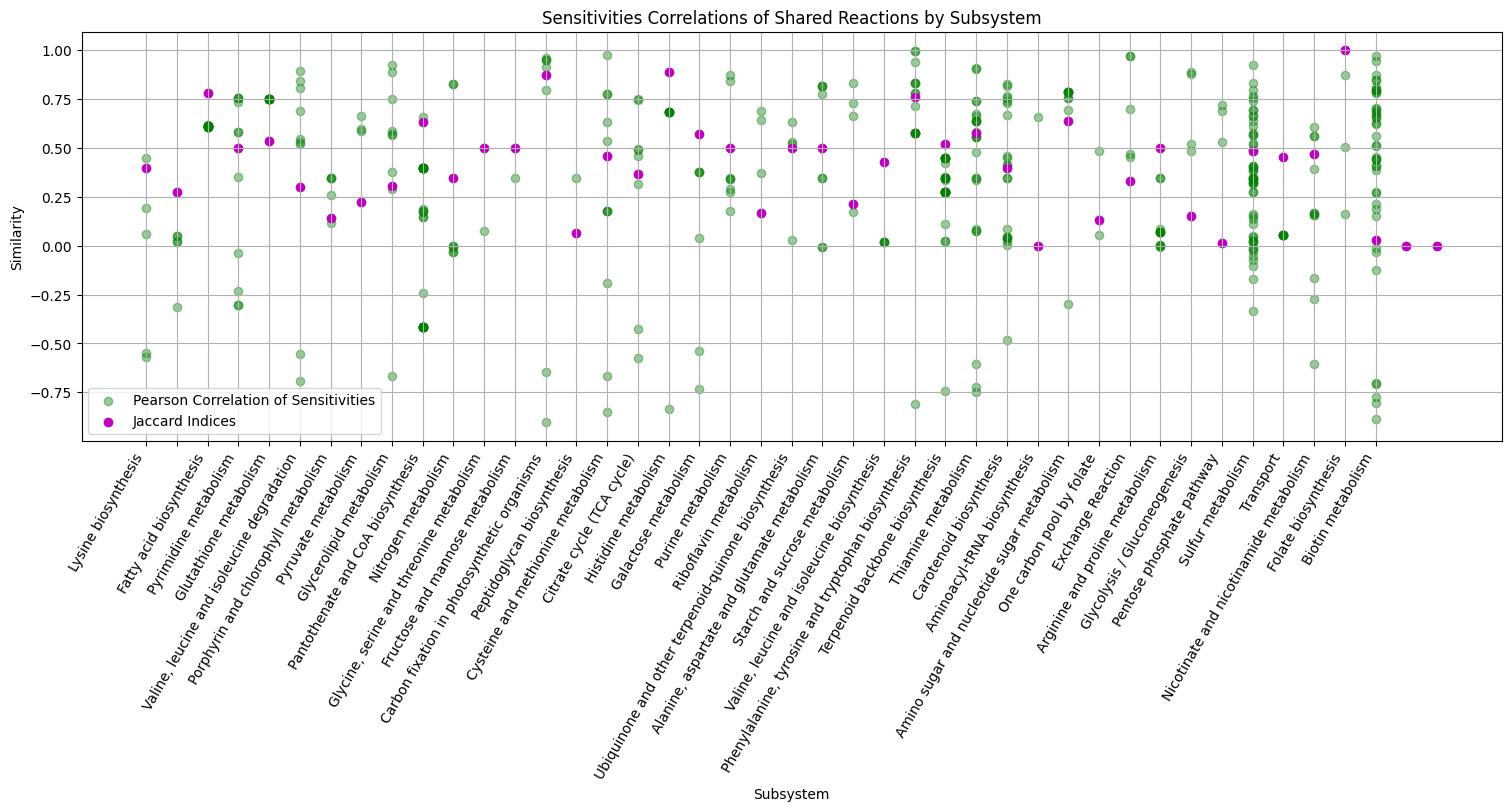

In [24]:
fig, ax = plt.subplots(figsize=(15, 8), layout='constrained')

ax.scatter(filtered_corr['subsystem'], filtered_corr['corr'], color='g', alpha=0.4, label='Pearson Correlation of Sensitivities')
ax.scatter(jaccard_subs_filtered.keys(), jaccard_subs_filtered.values(),  color='m', label='Jaccard Indices')
ax.legend()
ax.grid(True, axis='both')
ax.set_ylabel("Similarity")
ax.set_xlabel("Subsystem")
ax.set_title("Sensitivities Correlations of Shared Reactions by Subsystem")
# ax.tick_params('x', rotation=45)
ax.set_xticks(np.arange(len(set(filtered_corr['subsystem']))))
ax.set_xticklabels(set(filtered_corr['subsystem']), rotation=60, ha='right')
plt.show()

In [25]:
data = []
labels = []
for subsystem in elong_subsystems.keys():
    sub = []
    for rxn in filtered_corr.index:
        if filtered_corr.loc[rxn, 'subsystem'] == subsystem:
            sub.append(filtered_corr.loc[rxn, 'corr'])

    if len(sub) > 0:
        data.append(sub)
        labels.append(subsystem)

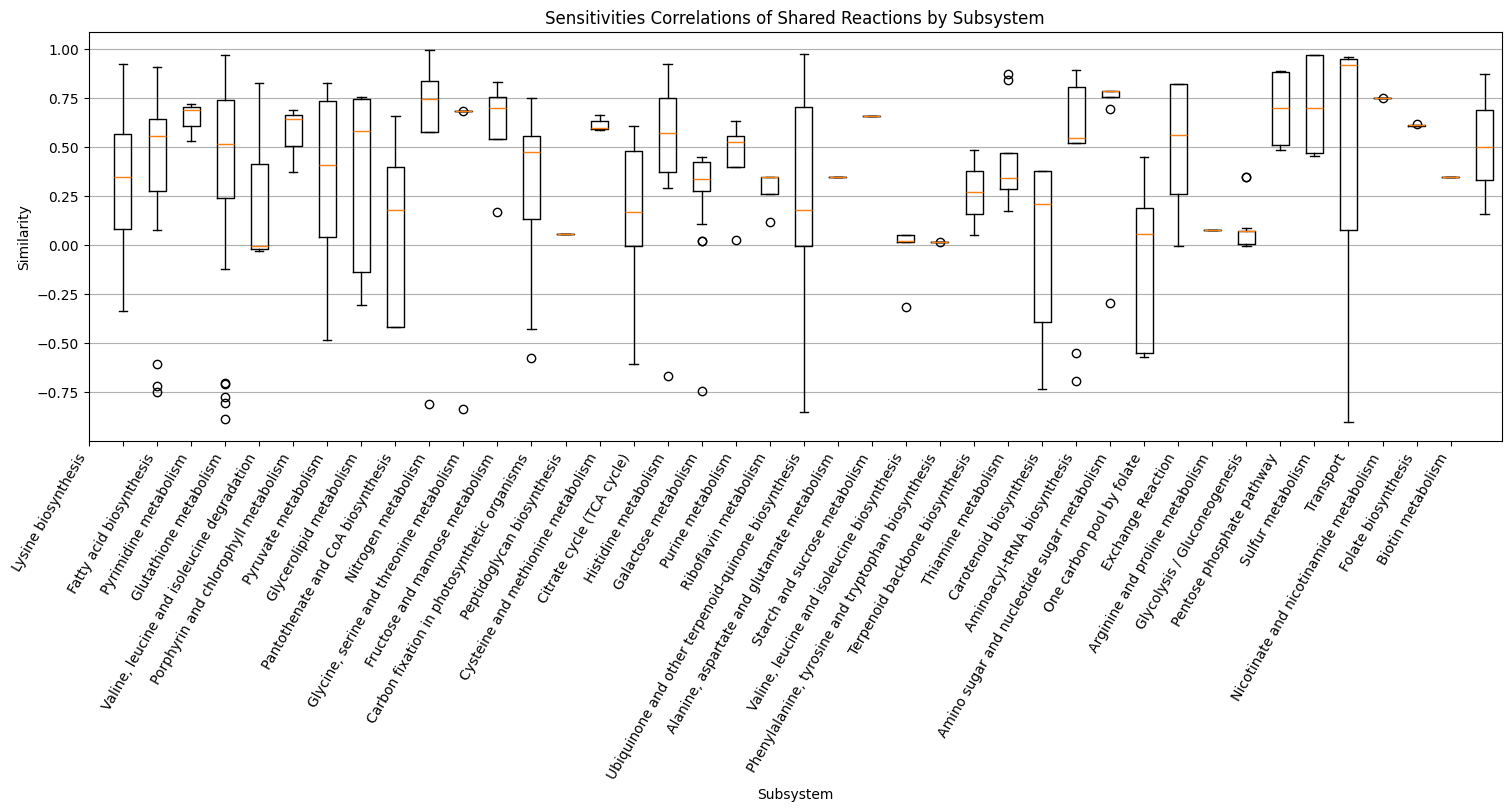

In [26]:
fig, ax = plt.subplots(figsize=(15,8), layout='constrained')
ax.boxplot(data, tick_labels=labels)

ax.set_ylabel("Similarity")
ax.set_xlabel("Subsystem")
ax.set_title("Sensitivities Correlations of Shared Reactions by Subsystem")
# ax.tick_params('x', rotation=45)
ax.set_xticks(np.arange(len(set(filtered_corr['subsystem']))))
ax.set_xticklabels(set(filtered_corr['subsystem']), rotation=60, ha='right')

ax.grid(True, axis='y')

plt.show()

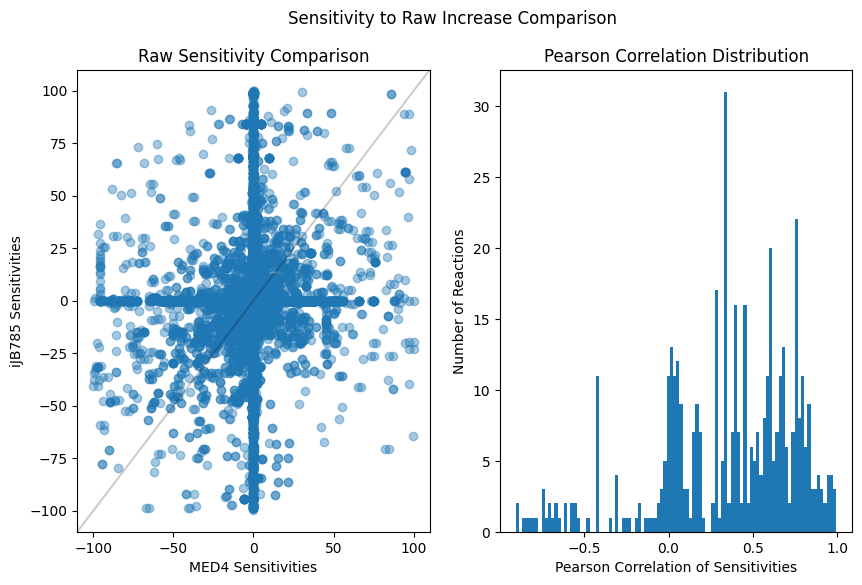

In [27]:
senses = all_sensitivities[abs(all_sensitivities['iJB785'])<100]
senses = senses[abs(senses['MED4'])<100]

fig, ax = plt.subplots(1,2,figsize=(10,6))

ax[0].scatter(senses['MED4'], senses['iJB785'], alpha=0.4, label='Reactions')
ax[0].set_xlabel('MED4 Sensitivities')
ax[0].set_ylabel('iJB785 Sensitivities')
ax[0].set_title('Raw Sensitivity Comparison')
ax[0].axline((-100, -100), slope=1, label='y=x', color = 'k', alpha=0.2)
# ax[0].set_xlim(-2,2)
# ax[0].set_ylim(-2,2)

ax[1].hist(correlations['corr'], 100)
ax[1].set_xlabel('Pearson Correlation of Sensitivities')
ax[1].set_ylabel('Number of Reactions')
ax[1].set_title('Pearson Correlation Distribution')

fig.suptitle("Sensitivity to Raw Increase Comparison")

plt.show()